In [3]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0']


In [7]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [8]:
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None)

False

In [9]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config = tf_config)

In [10]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7207485941235135383
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13408548359861143224
physical_device_desc: "device: XLA_CPU device"
]


In [11]:
#Playing around with the Jena weather dataset from 2009-2016
#Trying to make predictions on the temperature of the next day
#Inspecting the data
import os

data_dir = '/home/joel/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [12]:
lines[0:5]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60',
 '01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00',
 '01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30']

In [13]:
#Convert data in numpy arrays
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [14]:
float_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

In [15]:
#Plot of temperature over time

from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

<Figure size 640x480 with 1 Axes>

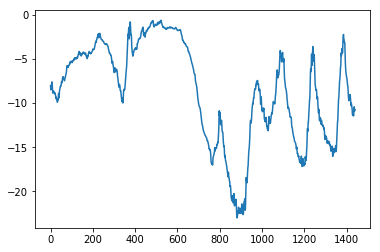

In [16]:
#Plot of the temperature in the first 10 days
plt.plot(range(1440), temp[:1440]) #one datapoint every 10 min makes 144 datapoints per day

In [17]:
#Normalizing the data

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [18]:
float_data[0]

array([ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
       -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
        2.12375056, -0.72950452, -0.78067973, -0.27613603])

In [19]:
#Generating timeseries samples and their targets

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    """
    data: The original array of floating point data, which we just normalized in the code snippet above.
    lookback: How many timesteps back should our input data go.
    delay: How many timesteps in the future should our target be.
    min_index and max_index: Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
    shuffle: Whether to shuffle our samples or draw them in chronological order.
    batch_size: The number of samples per batch.
    step: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [20]:
#generating train, val and test generator
#looking back 10 days, sampled at one datapoint per hour, targets 24 hours in the future

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [21]:
#Defining common sense baseline MAE

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [22]:
#Convert MAE back to Celsius

celsius_mae = 0.28974*std[1]
print(celsius_mae)

2.5649230840779667


In [23]:
#Basic machine learning approach

import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20


Using TensorFlow backend.


500/500 [==============================] - 9s 18ms/step - loss: 1.2021 - val_loss: 0.4836
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3585 - val_loss: 0.3206
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2820 - val_loss: 0.3504
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2596 - val_loss: 0.3031
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2489 - val_loss: 0.3392
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2426 - val_loss: 0.3229
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2345 - val_loss: 0.3078
Epoch 8/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2305 - val_loss: 0.3209
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2262 - val_loss: 0.3538
Epoch 10/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2227 - val_loss: 0.3223


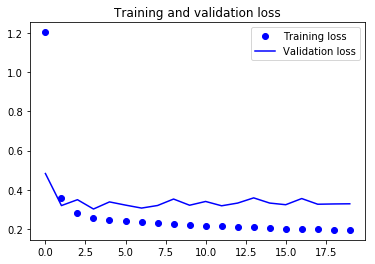

In [24]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 140s 280ms/step - loss: 0.3032 - val_loss: 0.2721
Epoch 2/20
500/500 [==============================] - 139s 279ms/step - loss: 0.2837 - val_loss: 0.2656
Epoch 3/20
500/500 [==============================] - 140s 279ms/step - loss: 0.2755 - val_loss: 0.2628
Epoch 4/20
500/500 [==============================] - 134s 268ms/step - loss: 0.2710 - val_loss: 0.2630
Epoch 5/20
500/500 [==============================] - 122s 243ms/step - loss: 0.2661 - val_loss: 0.2627
Epoch 6/20
500/500 [==============================] - 140s 279ms/step - loss: 0.2610 - val_loss: 0.2635
Epoch 7/20
500/500 [==============================] - 140s 279ms/step - loss: 0.2557 - val_loss: 0.2655
Epoch 8/20
500/500 [==============================] - 139s 279ms/step - loss: 0.2534 - val_loss: 0.2651
Epoch 9/20
500/500 [==============================] - 139s 279ms/step - loss: 0.2472 - val_loss: 0.2679
Epoch 10/20
500/500 [==============================] - 140s 280m

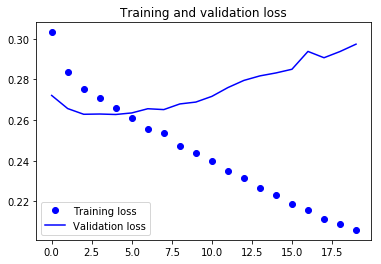

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
new_val_mae = 0.265 * std[1]
print(new_val_mae)

2.3459122567842243


In [29]:
#using dropout

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 154s 309ms/step - loss: 0.3412 - val_loss: 0.2771
Epoch 2/40
500/500 [==============================] - 157s 313ms/step - loss: 0.3147 - val_loss: 0.2736
Epoch 3/40
500/500 [==============================] - 156s 312ms/step - loss: 0.3082 - val_loss: 0.2711
Epoch 4/40
500/500 [==============================] - 156s 313ms/step - loss: 0.3039 - val_loss: 0.2737
Epoch 5/40
500/500 [==============================] - 156s 313ms/step - loss: 0.3009 - val_loss: 0.2656
Epoch 6/40
500/500 [==============================] - 156s 312ms/step - loss: 0.3009 - val_loss: 0.2661
Epoch 7/40
500/500 [==============================] - 156s 312ms/step - loss: 0.2957 - val_loss: 0.2657
Epoch 8/40
500/500 [==============================] - 156s 313ms/step - loss: 0.2952 - val_loss: 0.2685
Epoch 9/40
500/500 [==============================] -

KeyboardInterrupt: 

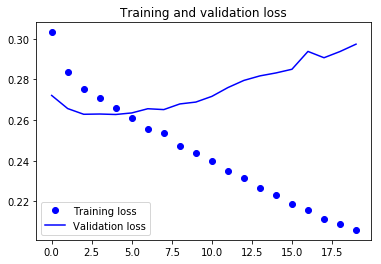

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#stacking recurrent layers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)